In [2]:
# 這個Jupyter Notebook的環境
import platform
import tensorflow
import keras
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython.display import Image

import os, shutil
from keras import layers
from keras import models
from keras.utils import plot_model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator





Using TensorFlow backend.


Platform: Windows-10-10.0.18362-SP0
Tensorflow version: 2.1.0
Keras version: 2.3.1


## 方法1: 卷積基底:提取特徴 + 串接新的密集分類層:重新訓練
我們來看看設置第一種方法所需的程式碼：在我們的數據上記錄“conv_base”的輸出，並使用這些輸出作為新模型的輸入。

我們將首先簡單地運行以前介紹的“ImageDataGenerator”的實例，以將圖像提取為Numpy數組及其標籤。我們將通過調用conv_base模型的predict方法從這些圖像中提取特徵。

In [3]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 置放coco圖像資料與標註資料的目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 原始數據集的路徑
original_dataset_dir = os.path.join(DATA_PATH, "train")

# 存儲小數據集的目錄
base_dir = os.path.join(DATA_PATH, "cats_and_dogs_small")
if not os.path.exists(base_dir): 
    os.mkdir(base_dir)

# 我們的訓練資料的目錄
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir): 
    os.mkdir(train_dir)

# 我們的驗證資料的目錄
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir): 
    os.mkdir(validation_dir)

# 我們的測試資料的目錄
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)    

# 貓的圖片的訓練資料目錄
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# 狗的圖片的訓練資料目錄
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# 貓的圖片的驗證資料目錄
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# 狗的圖片的驗證資料目錄
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# 貓的圖片的測試資料目錄
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# 狗的圖片的測試資料目錄
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, # 在這裡告訴 keras我們只需要卷積基底的權重模型資訊
                  input_shape=(150, 150, 3)) # 宣告我們要處理的圖像大小與顏色通道數



In [5]:
conv_base.summary() # 打印一下模型資訊

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [22]:
datagen = ImageDataGenerator(rescale=1./255) # 產生一個"圖像資料產生器"物件

batch_size = 20 # 設定每次產生的圖像的數據批量

# 提取圖像特徵
def extract_features(directory, sample_count): # 影像的目錄, 要處理的圖像數
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # 根據VGG16(卷積基底)的最後一層的輪出張量規格
    labels = np.zeros(shape=(sample_count)) # 要處理的圖像數
    
    # 產生一個"圖像資料產生器"實例(資料是在檔案目錄中), 每呼叫它一次, 它會吐出特定批次數的圖像資料
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),  # 設定圖像的高(height)與寬(width)
        batch_size=batch_size,   # 設定每次產生的圖像的數據批量
        class_mode='binary')     # 因為我們的目標資料集只有兩類(cat & dog)
    
    # 讓我們把訓練資料集所有的圖像都跑過一次
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) # 透過“卷積基底”來淬取圖像特徵
        features[i * batch_size : (i + 1) * batch_size] = features_batch # 把特徴先存放起來
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch #把標籤先存放起來
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    
    print('extract_features complete!')
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000) # 訓練資料的圖像特徵淬取
validation_features, validation_labels = extract_features(validation_dir, 1000) # 驗證資料的圖像特徵淬取
test_features, test_labels = extract_features(test_dir, 1000) # 測試資料的圖像特徵淬取

Found 2000 images belonging to 2 classes.
extract_features complete!
Found 1000 images belonging to 2 classes.
extract_features complete!
Found 1000 images belonging to 2 classes.
extract_features complete!


In [23]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [24]:
# 產生一個新的密集連接層來做為分類器
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid')) # 因為我的資料集只有兩類(cat & dog)

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

# 把透過預處理的卷積基底所提取的特徵做為input來進行訓練
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6156 - acc: 0.6665 - val_loss: 0.4389 - val_acc: 0.8290
Epoch 2/30
2000/2000 [==============================] - 2s 847us/step - loss: 0.4361 - acc: 0.7945 - val_loss: 0.3813 - val_acc: 0.8320
Epoch 3/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3613 - acc: 0.8475 - val_loss: 0.3269 - val_acc: 0.8700
Epoch 4/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.3182 - acc: 0.8690 - val_loss: 0.3042 - val_acc: 0.8810TA: 0s - loss: 0.3308 
Epoch 5/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2793 - acc: 0.8885 - val_loss: 0.2880 - val_acc: 0.8820
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2577 - acc: 0.9000 - val_loss: 0.2775 - val_acc: 0.8890
Epoch 7/30
2000/2000 [==============================] - 2s 971us/step - loss: 0.2442 - acc: 0.9050 - val_loss: 0.2821 - val_

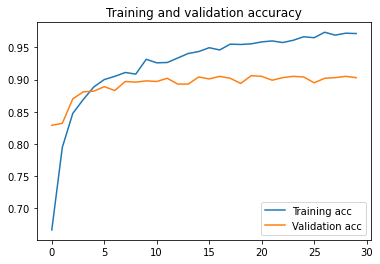

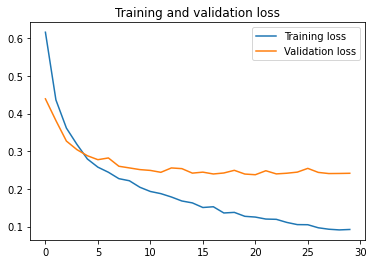

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

##  方法2: (卷積基底:凍結 + 串接新的密集分類層) >> 重新訓練
現在，我們來回顧一下我們提到的第二種特徵提取技術，這種方法要慢得多，而且會花更多的時間與計算資源，但是我們可以在訓練過程中利用數據擴充(data augmentation): 擴展conv_base模型，並進行端(end)對端(end)的訓練。

請注意，這種手法真的是非常昂貴的，所以只有在你有GPU時才應該嘗試它：在CPU上是絕對棘手的。如果您無法在GPU上運行代碼，那麼前一個手法就是你要選的路。

因為模型的行為就像堆積木，所以你可以添加一個模型（像我們的conv_base）到Sequential模型，就像添加一個圖層一樣。所以你可以執行以下操作：

In [27]:
model = models.Sequential() # 產生一個新的網絡模型結構

model.add(conv_base)        # 把預訓練的卷積基底疊上去
model.add(layers.Flatten()) # 打平
model.add(layers.Dense(256, activation='relu'))  # 疊上新的密集連接層來做為分類器
model.add(layers.Dense(1, activation='sigmoid')) # 因為我的資料集只有兩類(cat & dog)

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [32]:
# “凍結”卷積基底
conv_base.trainable = False

# 再看一下“凍結後”有多少可以被訓練的權重
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [29]:


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# 請注意: 驗證用的資料不要進行資料的增強
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 圖像資料的目錄
        train_dir,
        # 設定圖像的高(height)與寬(width)
        target_size=(150, 150),
        batch_size=20,
        # 因為我們的目標資料集只有兩類(cat & dog)
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 53s - loss: 0.1900 - acc: 0.9240 - val_loss: 0.1022 - val_acc: 0.9440
Epoch 2/30
 - 66s - loss: 0.1834 - acc: 0.9240 - val_loss: 0.0085 - val_acc: 0.9450
Epoch 3/30
 - 71s - loss: 0.1724 - acc: 0.9290 - val_loss: 0.0909 - val_acc: 0.9460
Epoch 4/30
 - 63s - loss: 0.1554 - acc: 0.9350 - val_loss: 0.0135 - val_acc: 0.9530
Epoch 5/30
 - 64s - loss: 0.1478 - acc: 0.9390 - val_loss: 0.2727 - val_acc: 0.9480
Epoch 6/30
 - 63s - loss: 0.1599 - acc: 0.9355 - val_loss: 0.0665 - val_acc: 0.9450
Epoch 7/30
 - 62s - loss: 0.1623 - acc: 0.9305 - val_loss: 0.1253 - val_acc: 0.9480
Epoch 8/30
 - 62s - loss: 0.1551 - acc: 0.9400 - val_loss: 0.0329 - val_acc: 0.9470
Epoch 9/30
 - 61s - loss: 0.1466 - acc: 0.9425 - val_loss: 0.0328 - val_acc: 0.9560
Epoch 10/30
 - 62s - loss: 0.1484 - acc: 0.9420 - val_loss: 0.1012 - val_acc: 0.9500
Epoch 11/30
 - 63s - loss: 0.1501 - acc: 0.9400 - val_loss: 0.0772 - val_ac

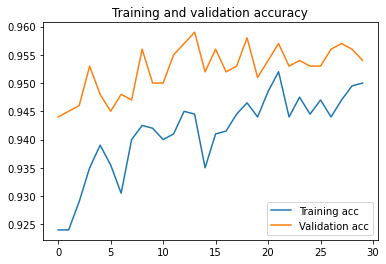

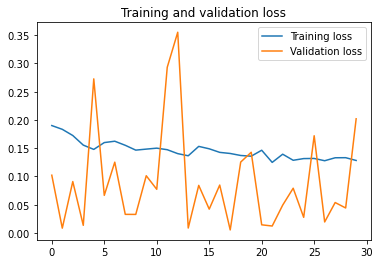

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

## 微調 (fine-tuning)
另一種廣泛使用的模型重覆利用技術，與_特徵提取(feature extraction)相輔相成，是 (微調) fine-tuning_。

微調包括解凍用於特徵提取的凍結模型庫中的幾個頂層(top layers)，並且共同訓練新添加的模型部分（在我們的範例中是完全連接的分類器）和這些頂層。這被稱為“微調(fine-tuning)”，因為它稍微調整正在重複使用的模型中更抽象的表示，以使它們與當前的要處理的問題更相關。

In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [12]:
conv_base.trainable = True # 解凍 "卷積基底"

# 所有層直到block4_pool都應該被凍結，而 block5_conv1，block5_conv2, block5_conv3 及 block5_pool則被解凍        
layers_frozen = ['block5_conv1','block5_conv2', 'block5_conv3', 'block5_pool']
for layer in conv_base.layers:
    if layer.name in layers_frozen:
        layer.trainable = True
    else:
        layer.trainable = False
        
# 把每一層是否可以被"trainable"的flat打印出來
for layer in conv_base.layers:
    print("{}: {}".format(layer.name, layer.trainable))

input_1: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: True
block5_conv2: True
block5_conv3: True
block5_pool: True


In [11]:
model = models.Sequential() # 產生一個新的網絡模型結構

model.add(conv_base)        # 把預訓練的卷積基底疊上去
model.add(layers.Flatten()) # 打平
model.add(layers.Dense(256, activation='relu'))  # 疊上新的密集連接層來做為分類器
model.add(layers.Dense(1, activation='sigmoid')) # 因為我的資料集只有兩類(cat & dog)




train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# 請注意: 驗證用的資料不要進行資料的增強
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 圖像資料的目錄
        train_dir,
        # 設定圖像的高(height)與寬(width)
        target_size=(150, 150),
        batch_size=20,
        # 因為我們的目標資料集只有兩類(cat & dog)
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/50
100/100 [==============================] - 58s 580ms/step - loss: 0.5073 - acc: 0.7450 - val_loss: 0.2651 - val_acc: 0.8930
Epoch 2/50
100/100 [==============================] - 55s 549ms/step - loss: 0.3202 - acc: 0.8645 - val_loss: 0.3258 - val_acc: 0.9090
Epoch 3/50
100/100 [==============================] - 57s 572ms/step - loss: 0.2894 - acc: 0.8745 - val_loss: 0.3785 - val_acc: 0.9110
Epoch 4/50
100/100 [==============================] - 63s 634ms/step - loss: 0.2578 - acc: 0.8855 - val_loss: 0.1052 - val_acc: 0.9180
Epoch 5/50
100/100 [==============================] - 76s 760ms/step - loss: 0.2408 - acc: 0.9025 - val_loss: 0.4238 - val_acc: 0.9260
Epoch 6/50
100/100 [==============================] - 67s 669ms/step - loss: 0.2170 - acc: 0.9075 - val_loss: 0.1156 - val_acc: 0.9190
Epoch 7/50
100/100 [==============================] - 66s 656ms/step - loss: 0.2069 - acc: 0.9180 - val_loss: 0.0680 - val_acc: 0.9220
Epoch 8/50
100/100 [==============================] - 6

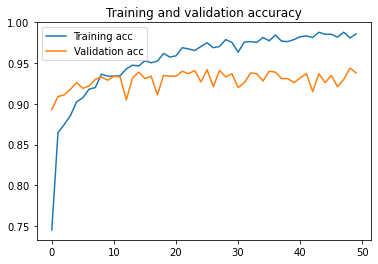

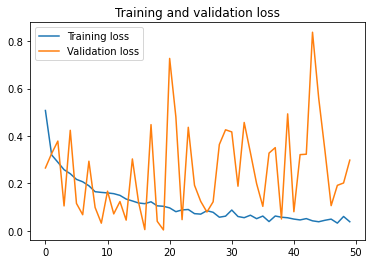

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()